# Aliasing - Don't Sample Too Slowly

The highest frequency you can resolve in your measurement is $1/2\Delta t$, the Nyquist frequency. This is exactly the same effect that shows up if you simulate a real system in software with too slow a delta t!



Import the usual collection of libraries

In [40]:
# gets all of numpy but you will still need to refer to e.g. numpy.random.randn() as random.randn()
from numpy import *               # all of the array capable elements for numerical data          
from scipy.stats import norm      # comprehensive functions for Gaussian normal distributions
import csv                        # library for reading and writing comma separated value files
from matplotlib.pyplot import *   # all of pyplot to graph the results of our calculations

# put figures inline in the notebook, so you don't have to call show()
%matplotlib inline

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
figsize(14, 7)

## Create some data to analyze

Imagine a V-8 engine with crankshaft turning at a steady speed. The cam shaft will rotate at half the speed for a four stroke engine. Cylinders will fire 4 times per rotation. Gear teeth in the timing system will engage and strike each other at many times the rate of rotation, and will be in synchronized periods, repeating the same engine timing around and around every 2 rotations of the crank shaft. An accelerometer mounted to the engine will pick up vibrations at all of these frequencies because none of these elements are in perfect balance. There will also be some continuous offset value because of gravity and orientation, plus lots of other vibrations from the other moving parts in the engine. Though incomplete, this model gives us enough to see the effects.

We'll start off by taking data very fast with no low pass filter on the input.

Frequencies for camshaft    17, crankshaft    33, firing   133, and gear teeth  3333


(0.2, 0.4)

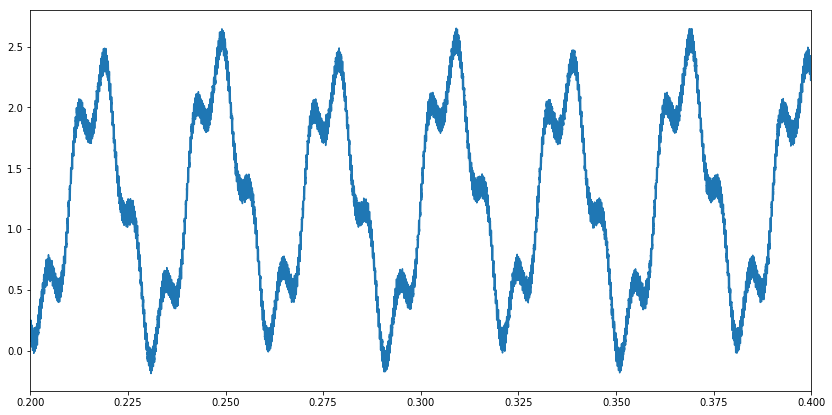

In [67]:
def getA(N = 2000,Pstart = pi-3,P = .5234,dt = .00001, fL = 10000000):
    # Period / dt gives number of steps, plus 1 for start and end
    # plus 0.1 to round up to get number of samples in the time series
    # then integer conversion so it can be an array index
    n = int(P/dt+1.1)       
    t = linspace(Pstart,Pstart+P,n)     # a time scale with n points
    f1 = N/60                           # convert from RPM to Hz
    A = sin(t*f1*2.0*pi)                # Crankshaft rotation
    A += 0.1 * sin(t*f1/2*2.0*pi)       # lower frequency from the camshaft
    if(fL > f1*4):                      # include only if lower than low pass filter fL
        A += 0.3 * sin(t*f1*4*2.0*pi)   # higher frequency from the cylinders firing
    if(fL > f1*100):                    # include only if lower than low pass filter fL
        A += 0.08 * sin(t*f1*100*2.0*pi)# much higher frequency from the gear teeth
    A += 0.01 * random.randn(n)         # random LF noise
    if(fL > 1/2/dt):                    # include only if lower than low pass filter fL
        A += 0.01 * random.randn(n)     # random HF noise
    A += 1.234                          # gravity offset due to orientation of accelerometer
    print('Frequencies for camshaft %5.0f, crankshaft %5.0f, firing %5.0f, and gear teeth %5.0f'%(f1/2,f1,f1*4,f1*100))
    return (t,A)

t,a = getA()
plot(t,a)
xlim(.2,.4)
#xlim(.15,.17)       # zoom in to see the regular, but small signals from the teeth

Now take data more slowly both with and without a low pass filter to cut off frequencies higher than $1/2\Delta t$. Which one provides a more realistic representation? Often your low pass filter will simply be a capacitor added to the output of your transducer

Frequencies for camshaft    17, crankshaft    33, firing   133, and gear teeth  3333
Frequencies for camshaft    17, crankshaft    33, firing   133, and gear teeth  3333


(0.15, 0.17)

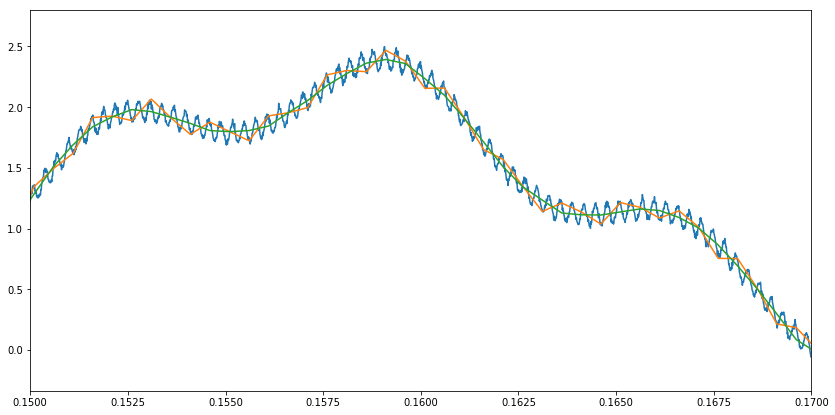

In [65]:
t1,a1 = getA(dt = 0.0005)          # sample too slow and alias the higher frequency information
t2,a2 = getA(dt = 0.0005,fL=500)   # sample slow, but with low pass fL = 1/2dt
plot(t,a)
plot(t1,a1)
plot(t2,a2)
xlim(.15,.17)       # zoom in to see the regular, but small signals from the teeth

## High frequencies alias down!

The first set of data at high sample rate captures four peaks, the camshaft, the crankshaft, the firings and the gear teeth, all at the frequencies we put in the model.

In the second set of data we didn't set our delta t small enough to capture the gear tooth frequency, so it aliased down to a frequency lower than $1/2\Delta t$. We lost information because we didn't sample often enough and there is no way to tell if the fourth peak in the slowly sampled data is real, or just something at a higher frequency that has aliased down.

**Make sure to remove any high frequencies from your raw input with an analog low pass filter**, otherwise you will see the full frequency range of the measurement system.

**Sample your data at a rate that is at least twice the highest frequency remaining in your data after filtering.** Otherwise you will get false peaks in the spectrum.

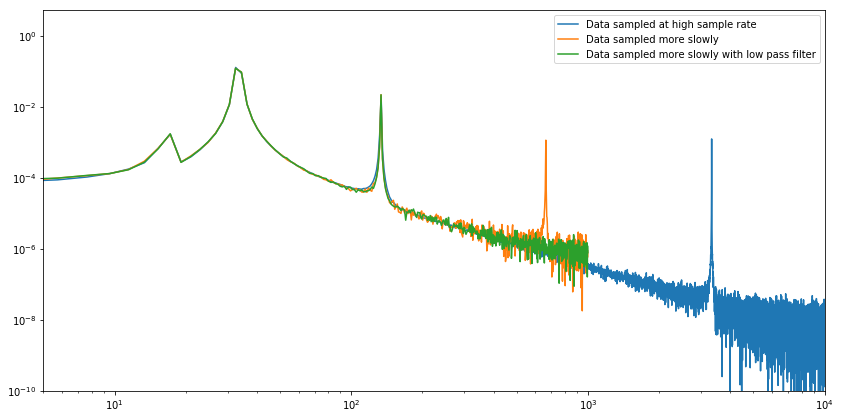

In [66]:
from scipy.signal import periodogram
f,p = periodogram(a,1/(t[1]-t[0]))
f1,p1 = periodogram(a1,1/(t1[1]-t1[0]))
f2,p2 = periodogram(a2,1/(t2[1]-t2[0]))
loglog(f,p, label='Data sampled at high sample rate')
loglog(f1,p1, label = 'Data sampled more slowly')
loglog(f2,p2, label = 'Data sampled more slowly with low pass filter')
ylim(1e-10)
xlim(5,10000)
legend()